**Work flow in machine learning means the entire steps from start to finish that projects usually follows when they are executed.**

**It actually tells how a model works from scratch. To solve a problem using machine learning several steps are involved which in their own respect are very useful to the model to get desired result.**

### **Step by step workflow in machine learning:**

**1. Getting / Retrieve Data**

**2. Pre-processing data**

**3. Build a model**

**4. Evaluate model**

**5. Saving Model**

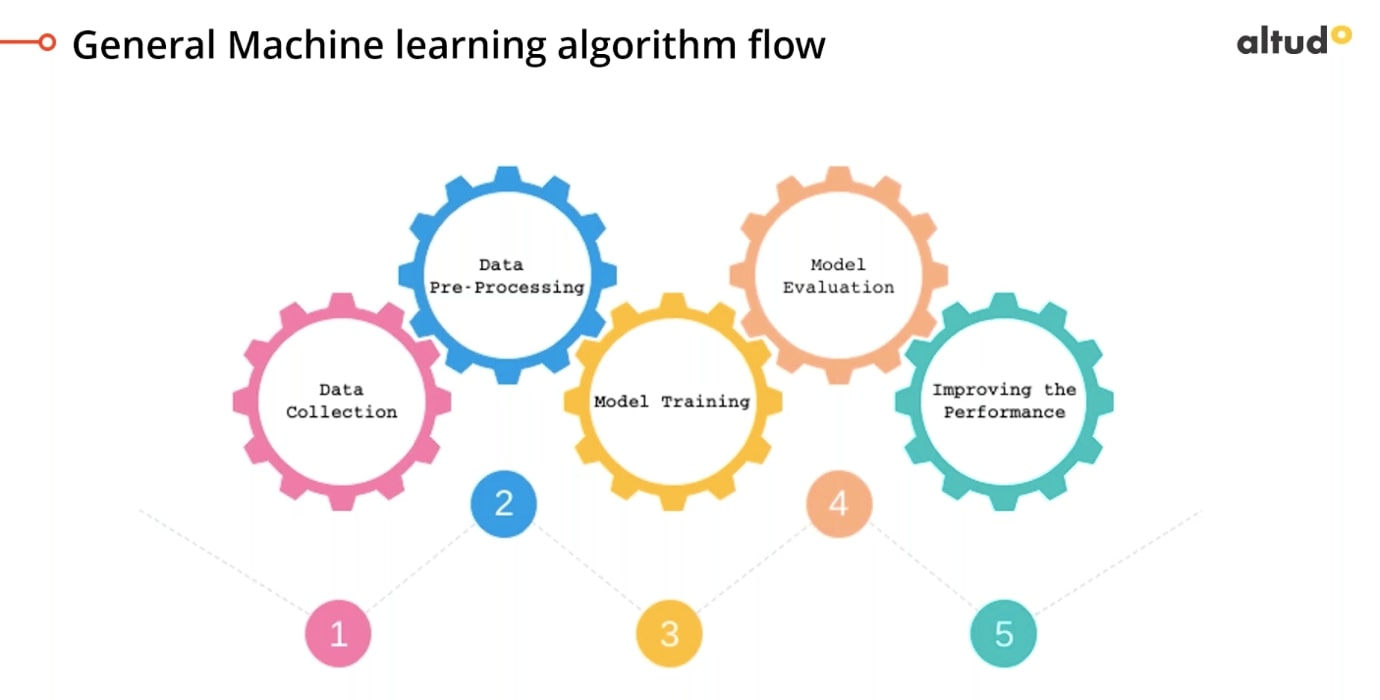

**Here, the problem of using electrical energy in households will be resolved, where a deep learning model will be made to predict the use of electrical energy every 1 hour for a day and find out how long the remaining electric pulses will run out.**

## **1.Getting or Retrieve Data**
**Dataset obtained from data collection for 22 days. The dataset collection was carried out by taking pictures on a kwh meter in one of the charm houses in Bali, Dayeuhkolot sub-district, Bandung Regency.**

- **pulsa_listrik**: Contains the data column for the user's remaining electricity pulse every 1 hour.
- **pemakaian_listrik**: Contains column data of the user's electricity consumption in 1 hour.
- **tanggal**: Contains column data from the date of use of electricity users


In [1]:
#import library

import numpy as np
import pandas as pd

#importing visualization graph
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('classic')
%matplotlib inline
import missingno as mno

#importing time
import time

#importing tensorflow keras model LSTM
import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.models import load_model

#importing evaluate metric error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape


In [2]:
#read data into dataframe on data

df_data = pd.read_excel('pemakaian listrik.xlsx')

In [3]:
#show dataframe with 5 data from initial data

df_data.head(5)

,tanggal,pulsa_listrik,pemakaian_listrik
0,2022-01-29 20:02:34,163.04,NaN
1,2022-01-29 21:02:43,162.37,0.67
2,2022-01-29 22:02:52,161.89,0.48
3,2022-01-29 23:03:01,161.42,0.47
4,2022-01-30 00:03:10,160.96,0.46


In [4]:
#see the data type
df_data.dtypes

tanggal               object
pulsa_listrik        float64
pemakaian_listrik    float64
dtype: object

In [5]:
#see descriptions on data 

df_data.describe(include="all")

,tanggal,pulsa_listrik,pemakaian_listrik
count,522,519.000000,514.000000
unique,522,NaN,NaN
top,2022-01-29 20:02:34,NaN,NaN
freq,1,NaN,NaN
mean,NaN,244.159152,0.424183
std,NaN,110.544352,0.142045
min,NaN,72.340000,0.150000
25%,NaN,130.565000,0.320000
50%,NaN,284.640000,0.410000
75%,NaN,342.345000,0.500000


**Total data = 514 (only the existing data is taken. NaN is ignored)**

**Average electricity usage is around 0.42**

**The minimum value of all data is 0.15**

**Max value of all data is 1.04**

**The standard deviation (data distribution) is 0.140951**

In [6]:
#see the number of data columns and rows
df_data.shape

(522, 3)

**The dataset have 3 columns and 522 rows. The column of pemakaian_listrik and tanggal is used by prediction**

## **2.Pre-processing Data**

- **Improve Quality of the data for Model so that the performance of the data model is better (make data not ready will be ready)**


In [7]:
#convert type data object to float
df_data["pemakaian_listrik"] = pd.to_numeric(df_data["pemakaian_listrik"], downcast="float") 
    
#convert type data object to datetime   
df_data['tanggal'] = pd.to_datetime(df_data["tanggal"])

**Take only the columns that are needed, namely the date and electricity_consumption columns. Change the index data by using the date column into time series data. Then, reformat the date on the data to make it clear that the intervals coincide every 1 hour.**

In [8]:
#function indexing date in dataset

def transform_data(data_value):
    
    #convert type data object to float
    data_value["pemakaian_listrik"] = pd.to_numeric(data_value["pemakaian_listrik"], downcast="float") 
    
    #convert type data object to datetime
    data_value['tanggal'] = pd.to_datetime(data_value["tanggal"])
    
    #just take 2 column
    data_value = data_value[['tanggal','pemakaian_listrik']]
    
    #make index which was originally an integer to be a date time
    data_value = data_value.set_index('tanggal')
    
    #reformattted date
    lenght_data = len(data_value)
    tanggal_awal = data_value.index[0]
    data_value.index = pd.date_range(tanggal_awal, periods=lenght_data, freq='H')
    
    return data_value

In [9]:
pd.options.mode.chained_assignment = None  # default='warn'

#call function reindex_date
df_data = transform_data(df_data)

In [10]:
df_data.head(5)

,pemakaian_listrik
2022-01-29 20:02:34,NaN
2022-01-29 21:02:34,0.67
2022-01-29 22:02:34,0.48
2022-01-29 23:02:34,0.47
2022-01-30 00:02:34,0.46


In [11]:
#Show IQR (Jangkauan Interquartile) 

q1= df_data['pemakaian_listrik'].quantile(0.25)
q3 = df_data['pemakaian_listrik'].quantile(0.75)
iqr = round(q3 - q1, 2)

In [12]:
#Show data_deskripsi outliers data with tukey's fences (1)

#handle warning
import warnings
warnings.filterwarnings('ignore')

#outlier filter (pencilan) on data 

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [13]:
#showing outlier in the data
df_data[(df_data['pemakaian_listrik'] < lower_bound) | (df_data['pemakaian_listrik'] > upper_bound)]

,pemakaian_listrik
2022-01-30 19:02:34,0.79
2022-02-02 19:02:34,0.82
2022-02-03 19:02:34,1.04
2022-02-04 19:02:34,0.78
2022-02-04 20:02:34,0.88
2022-02-05 19:02:34,0.80
2022-02-09 18:02:34,0.90
2022-02-10 20:02:34,0.78
2022-02-11 18:02:34,0.85
2022-02-12 18:02:34,0.81


**We can see this, Data Description have 15 Data Outlier**

**Remember!**

**Each algorithm has different characteristics. such as the LSTM Algorithm, RNN based on Deep Learning can be used to overcome such outlier data without having to eliminate the data as in statistical rules.**

In [14]:
#fill data outlier with mean

df_data.loc[(df_data['pemakaian_listrik'] < lower_bound) | (df_data['pemakaian_listrik'] > upper_bound)] = np.nan

In [15]:
#make function missing value for the data

def cleaning_missingValue(data_value):
    try:
        if data_value['pemakaian_listrik'].isna().sum() > 0 or (data_value['pemakaian_listrik'] == 0).sum() > 0:
            print("")
            print("There is data that is empty, fill in the data with the average !")
            print("")
            time.sleep(1)
      
            #fill missing value and data zero with mean value in all data
            data_value['pemakaian_listrik'] = data_value['pemakaian_listrik'].fillna(data_value['pemakaian_listrik'].mean())
            data_value['pemakaian_listrik'] = data_value['pemakaian_listrik'].mask(data_value['pemakaian_listrik'] == 0).fillna(data_value['pemakaian_listrik'].mean())

            print("NULL data added successfully !")
        else:
            print("")
            print("Congratulations, no data is empty !")
        return round(data_value, 2)
    except:
        print('Data error occurred !!')

In [16]:
#call fuction missing value

df_data = cleaning_missingValue(df_data)


There is data that is empty, fill in the data with the average !

NULL data added successfully !


In [17]:
df_data.head(5)

,pemakaian_listrik
2022-01-29 20:02:34,0.41
2022-01-29 21:02:34,0.67
2022-01-29 22:02:34,0.48
2022-01-29 23:02:34,0.47
2022-01-30 00:02:34,0.46


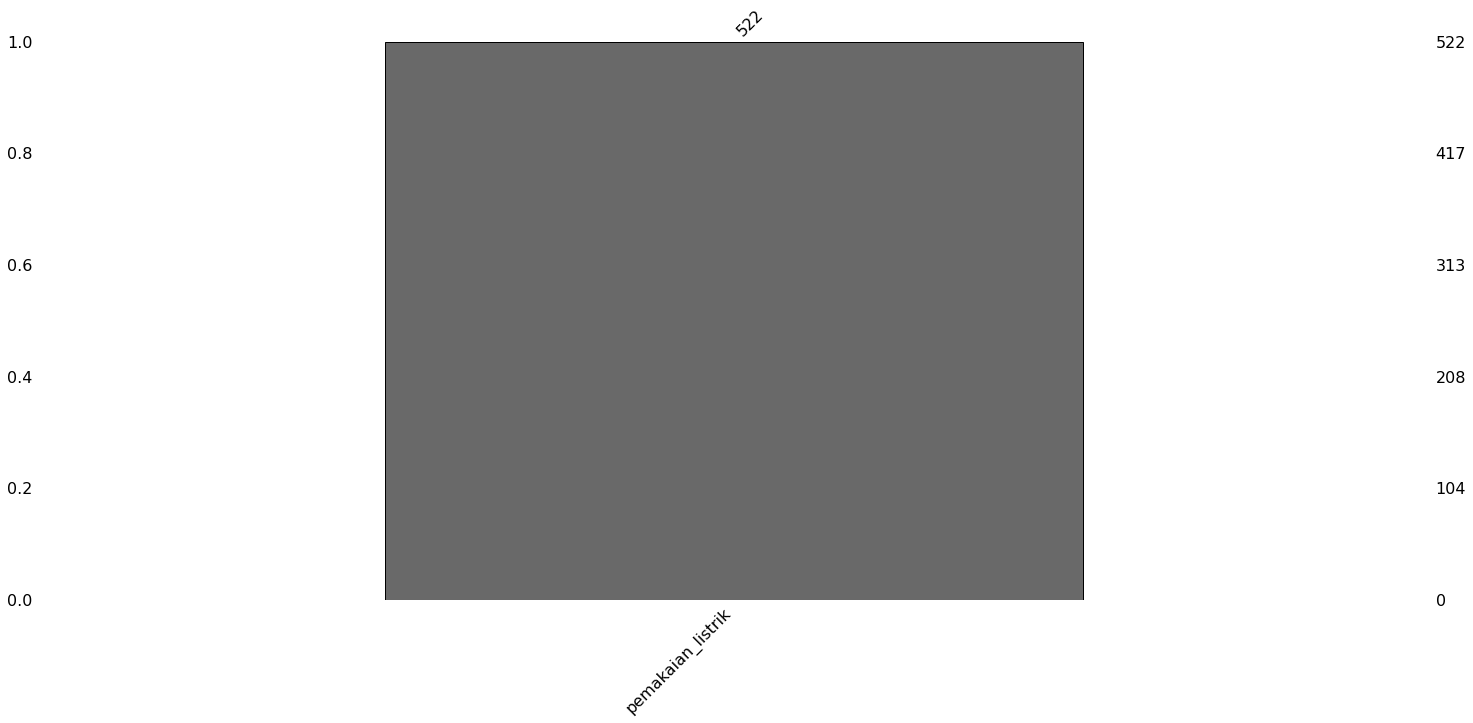

In [18]:
#visualisasi data missing value

#menjalankan visualisasi dalam grafik bar.
mno.bar(df_data)

**You can see, the data missing value has been cleared with filling this using average by all data not missing. And graph is showing fulled color or not break**

In [19]:
#visualization data pemakaian listrik to show distribution data

fig = px.histogram(df_data.pemakaian_listrik, nbins=100, labels={'value': 'Pemakaian_Listrik', 'Count': 'Count of Distribution'},
                   marginal='violin', title='Distribution Data Electricity Usage',
                   color_discrete_sequence=px.colors.sequential.RdBu)

fig.update_layout(showlegend=False)

fig.show()


**You can see in this graph, Outlier data has been cleaned (No outlier the Data). then, Most of the electricity consumption data is in the range of 0.2 until 0.6. you can call this data is constant or stasioner in statistic. so, i'm looking the data is very good.**


## **3. Modelling**

### **Why Choose LSTM?**

1. From the amount of data. The data used is more than 500. Assume that the data is always growing continuously and the data will become very large. LSTM is very suitable for such a lot of data.

2. LSTM can handle sequential data such as time series and NLP.

3. LSTM can handle non-linear data types or there are outliers.

4. There is no need to assume the data is stationary or not. LSTM can handle both.

5. LSTM has a good performance in predicting electrical energy data such as this data.**

### **Splitting Data**

**Data Train : Data will taken for training model LSTM**

**Test data  :  Data will be taken for model evaluation**

In [20]:
#copy data that all is cleared.

data = df_data.copy()

In [21]:
#name for save picture (for test evaluate)

uji_name        = "pengujian_LearningRate"
uji_ke          = "uji-ke-3"
validasi_uji_ke = "validasi-ke-5"

In [24]:
#Calculate data train and testing by percent

data_all = len(data)

#Estimate Data by %

persen_data_validation_test = 20
persen_data_train = 80

jumlah_data__validation_test  = int((persen_data_validation_test/100) * data_all)
jumlah_data_train = data_all - jumlah_data__validation_test

print("jumlah data validation dan train :", (jumlah_data__validation_test, jumlah_data_train))

jumlah data validation dan train : (104, 418)


In [28]:
#spliting data training and testing

training_test = data[:-104]
validation_test = data[-104:]

print("shape data training test: " + str(training_test.shape))
print("shape data validation test: " + str(validation_test.shape))

shape data training test: (418, 1)
shape data validation test: (104, 1)


**Converting Data Into Sequence**
- where x1, x2, x3 is input for Deep Neural Network in LSTM
- where y1, y2, y3 is output (prediction) for Deep Neural Network in LSTM

In [29]:
#transform into a sequence function.

def sequence_data_transformasi(data, window_size):

  df_as_np = data.to_numpy()
  X = []
  y = []

  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [30]:
#Change to data sequence

WINDOW_SIZE = 5

#for train data
input_train, output_train = sequence_data_transformasi(round(training_test['pemakaian_listrik'], 2), WINDOW_SIZE)

#for test data
input_test, output_test = sequence_data_transformasi(round(validation_test['pemakaian_listrik'], 2), WINDOW_SIZE)

print(input_train.shape, output_train.shape)
print(input_test.shape, output_test.shape)


(413, 5, 1) (413,)
(99, 5, 1) (99,)


**Estimated Parameter Input**

In [31]:
n_input = WINDOW_SIZE
n_output_label = 1

**Estimated Parameter Dense, Neuron, Epoch, Batch Size, Learning Rate**


- Neuron = output dimension (dimensi keluaran) of neurons or Number of Neurons in Hidden Layer
- Dense = Number of Hidden Layers. Dense(1) is the output units of the hidden layer. If you give the dense function below that, then there are 2 hidden layers
- In the LSTM Layer there is 1 Hidden Layer.
- Epoch = When all data has gone through the training process on the Neural Network until it is returned to the beginning for one round (1 Epoch). because 1 epoch is too large to be entered into a computer, therefore we need to divide it into small units called batches. (karena pada 1 Epoch terlalu besar untuk dimasukkan kedalam komputer maka dari itu kita perlu membaginya kedalam satuan kecil yang disebut batches.)

- Batch Size = Batch Size is the number of sample data distributed to the Neural Network. eg data 50, and batch size = 5. then the order of data to be entered into the neural network is [1,2,3,4,5], continue [6,7,8,9,10]

**Selecting Metric Loss**

1. Is the data a case of classification or regression?
2. What metrics are appropriate for this case?

In the Regression Case, the Error Metric which is suitable for Knowing the Performance of the Training and Evaluation Model will be used.

1. Mean Square Error (MSE)



```
      MSE = 1/n (ytrue - ypred)^2
```

In [ ]:
#in LSTM model, in input /forget/ output have function like regression or NN . 
#f(x) = wx + b. 
#where b set initialization is zero (nol).
#and w (weight) not zero !. because this independent with input. in tensorflow, w = random

In [36]:
#Modeling data LSTM

model = Sequential([
    LSTM(128, activation='relu', input_shape=(n_input, n_output_label)),
    Dense(1),                                      
])

#call model and training data
#loss MSE is for the error function, the optimizer is to lower the value of the error (Adam)

model.compile(loss=['mse'], optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00050
))
print(model.summary())

#1 epochs = 1 time for all training data from top to bottom to completion. .
history = model.fit(input_train, output_train, validation_data=(input_test, output_test), batch_size=1, epochs=150) #fit to execute the model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
413/413 [==============================] - 4s 7ms/step - loss: 0.0242 - val_loss: 0.0112
Epoch 2/150
413/413 [==============================] - 3s 6ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 3/150
413/413 [==============================] - 2s 6ms/step - loss: 0.0112 - val_loss: 0.0104
Epoch 4/150
413/413 [==============================] - 3s 7ms/step - loss: 0.0107 - val_loss: 0.0097
Epoch 5/150
413/413 [================

### **Evaluation Performance Model**

**- Data evaluation using data test**

**- The model is said to be not overfitting and underfitting if the error value in the test data / validation data is not much different from the error in the training data.**


**Overfitting : where the prediction results on the training data are good and when tested with original data, the results are bad**

**Underfitting : where the prediction results on the training data and testing data are very bad.**

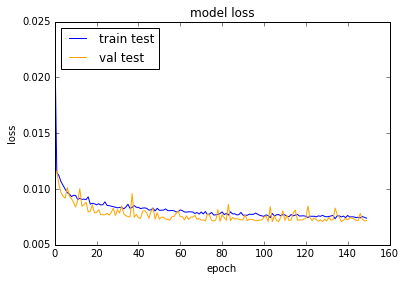

In [37]:
#make ploting loss function MSE

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color="orange")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train test', 'val test'], loc='upper left')
plt.savefig('error-{}-{}-{}.png'.format(uji_name,uji_ke, validasi_uji_ke))
plt.show()

In [38]:
#prediction for training data and transformed into dataframe

train_prediction = model.predict(input_train).flatten()
train_hasil= pd.DataFrame(data={'Predict':train_prediction, 'Train':output_train})
train_hasil.tail(5)

,Predict,Train
408,0.363564,0.45
409,0.430759,0.40
410,0.390365,0.43
411,0.424233,0.39
412,0.419997,0.34


Error MSE Data Training is:
413/413 [==============================] - 1s 2ms/step - loss: 0.0072
0.007158039137721062



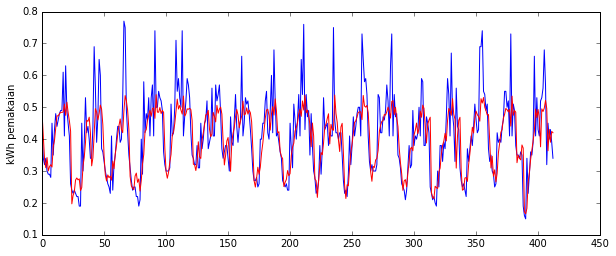

In [39]:
#Show the predicted results of train data in the form of a visualization graph
#model.evaluate to show final error by data. model.evalute error with MSE is same sklearn MSE 

print("Error MSE Data Training is:")
print(model.evaluate(input_train, output_train, batch_size=1,))
print("")

plt.figure(figsize=(10, 4))
plt.plot(train_hasil['Train'],label='Train', color='blue')
plt.plot(train_hasil['Predict'], label='Predict', color='red')
plt.ylabel("kWh pemakaian")
plt.xticks()
plt.yticks()
plt.savefig('grafik_prediksi_train_test-{}-{}-{}.png'.format(uji_name,uji_ke, validasi_uji_ke))
plt.show()


In [40]:
#prediction for testing data and transformed into dataframe

test_prediction = model.predict(input_test).flatten()
test_hasil = pd.DataFrame(data={'Predict':test_prediction, 'Test':output_test})
test_hasil.head(5)

,Predict,Test
0,0.400437,0.46
1,0.432669,0.48
2,0.455730,0.48
3,0.467312,0.43
4,0.474123,0.46


Error MSE Data Testing is : 0.007178343



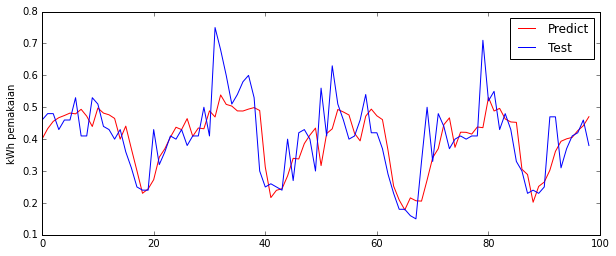

In [43]:
#Show the predicted results of train data in the form of a visualization graph

print('Error MSE Data Testing is :', mse(test_hasil['Test'], test_hasil['Predict']))
print("")

plt.figure(figsize=(10, 4))
plt.plot(test_hasil['Predict'], label='Predict', color='red')
plt.plot(test_hasil['Test'],label='Test', color='blue')
plt.ylabel("kWh pemakaian")
plt.xticks()
plt.yticks()
plt.legend()
plt.savefig('grafik_prediksi_test-{}-{}-{}.png'.format(uji_name,uji_ke, validasi_uji_ke))
plt.show()

In [44]:
#or using function model.evaluate is simple. the result is same in the top

model.evaluate(input_test, output_test, batch_size=1)

99/99 [==============================] - 0s 2ms/step - loss: 0.0072


0.007178342901170254

**Save model LSTM.**

In [46]:
model.save('model_{}-{}-{}-MSE-{}.h5'.format(uji_name,uji_ke, validasi_uji_ke, mse(test_hasil['Test'], test_hasil['Predict'])))

In [ ]:
#dari 100 model dari hasil pengujian dataset, pengujian lr, pengujian epoch, pengujian input. 